# **🌿 Plant Leaf Classification (Subset of PlantVillage Dataset)**
**CNN Model with Data Augmentation (under 15 epochs)**

In [1]:
import os
from google.colab import drive

# Mount Google Drive (optional, if you want to save results)
# drive.mount('/content/drive')

# Create Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# === Upload kaggle.json file manually when prompted ===
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Move it to Kaggle directory
for file_name in uploaded.keys():
    os.rename(file_name, "/root/.kaggle/kaggle.json")

# Set proper permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

# Verify Kaggle API is working
!kaggle datasets list -s plantvillage | head -n 10

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
ref                                                       title                                              size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
abdallahalidev/plantvillage-dataset                       PlantVillage Dataset                         4371949460  2019-09-01 11:52:26.883000          86256        782  0.875            
emmarex/plantdisease                                      PlantVillage Dataset                          689512690  2018-10-30 01:16:23.440000         124698        949  0.5625           
mohitsingh1804/plantvillage                               PlantVillage                                  857351099  2021-08-20 01:08:58.493000           8494         55  0.625            
soumiknafiul/plantvillage-datas

### SECTION 1: Setup & Kaggle API Configuration

This section handles the initial setup, including importing necessary libraries and configuring the Kaggle API for use within Google Colab.

#### Import Libraries

*   **`import os`**: Imports the `os` module, which provides a way of using operating system dependent functionality, like creating directories or managing file paths.
*   **`from google.colab import drive`**: Imports the `drive` module from `google.colab`, allowing you to mount your Google Drive to access or store files.
*   **`from google.colab import files`**: Imports the `files` module from `google.colab`, which provides utilities for uploading and downloading files to/from the Colab environment.

#### Mount Google Drive (Optional)

*   **`# drive.mount('/content/drive')`**: This line is commented out, but if uncommented, it would mount your Google Drive. This is useful if you want to save results or load data directly from your Drive. You would be prompted to authorize access.

#### Configure Kaggle API

To interact with Kaggle datasets and competitions, you need to set up your Kaggle API credentials. This involves placing your `kaggle.json` file in the correct directory with appropriate permissions.

##### Create Kaggle Directory

*   **`os.makedirs("/root/.kaggle", exist_ok=True)`**: This command creates a directory named `.kaggle` inside the `/root` directory. The `.kaggle` directory is where Kaggle expects to find your API credentials. `exist_ok=True` prevents an error if the directory already exists.

##### Upload `kaggle.json`

*   **`print("Please upload your kaggle.json file:")`**: Displays a message to the user.
*   **`uploaded = files.upload()`**: This command opens a file upload widget in Colab, prompting you to manually select and upload your `kaggle.json` file. This file contains your Kaggle API key and username. You can obtain it from your Kaggle account settings (under the 'API' section, click 'Create New API Token').

##### Move and Set Permissions

*   **`for file_name in uploaded.keys(): os.rename(file_name, "/root/.kaggle/kaggle.json")`**: After uploading, the `kaggle.json` file is moved from its temporary location to the newly created `/root/.kaggle/` directory and renamed to `kaggle.json` (if it wasn't already).
*   **`os.chmod("/root/.kaggle/kaggle.json", 600)`**: This command sets the file permissions for `kaggle.json` to `600`. This means only the owner (you) can read and write to the file, which is crucial for security as it contains sensitive API credentials.

##### Verify Kaggle API

*   **`!kaggle datasets list -s plantvillage | head -n 10`**: This is a shell command executed within Colab (indicated by the `!`).
    *   **`kaggle datasets list -s plantvillage`**: This uses the Kaggle CLI (Command Line Interface) to list datasets. The `-s plantvillage` flag searches for datasets containing the term "plantvillage".
    *   **`| head -n 10`**: This pipes the output of the previous command to `head -n 10`, which displays only the first 10 lines of the results. This is a quick way to verify that your Kaggle API is correctly configured and can communicate with Kaggle's servers.

In [2]:
# ====================================================
# SECTION 2: Download & Extract the Dataset
# ====================================================

# Download PlantVillage dataset from Kaggle
!kaggle datasets download -d emmarex/plantdisease

# Unzip dataset
!unzip -q plantdisease.zip -d /content/plantvillage

# Check directory structure
!ls /content/plantvillage


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 98% 646M/658M [00:01<00:00, 279MB/s]
100% 658M/658M [00:01<00:00, 382MB/s]
plantvillage  PlantVillage


**Description:**

This downloads the PlantVillage dataset and extracts it into the working directory.
We’ll later select only a few classes (3–5) to keep it light.

In [3]:
# ====================================================
# SECTION 3: Prepare Dataset (Subset Selection)
# ====================================================

import shutil
import os
import random

# Define source and destination directories
source_dir = "/content/plantvillage/PlantVillage"
subset_dir = "/content/plantvillage_subset"

os.makedirs(subset_dir, exist_ok=True)

# Choose 4 random classes
all_classes = os.listdir(source_dir)
selected_classes = random.sample(all_classes, 4)
print("Selected classes:", selected_classes)

# Copy few classes to subset folder
for cls in selected_classes:
    shutil.copytree(os.path.join(source_dir, cls), os.path.join(subset_dir, cls))

# Verify
for cls in selected_classes:
    print(f"{cls}: {len(os.listdir(os.path.join(subset_dir, cls)))} images")


Selected classes: ['Tomato__Tomato_mosaic_virus', 'Pepper__bell___Bacterial_spot', 'Tomato_Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']
Tomato__Tomato_mosaic_virus: 373 images
Pepper__bell___Bacterial_spot: 997 images
Tomato_Bacterial_spot: 2127 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images


**Description:**

**This code:**

Randomly selects 4 plant classes from the dataset.

Copies them into a smaller folder plantvillage_subset for faster training.

In [9]:
# ====================================================
# SECTION 4: Data Loading & Augmentation
# ====================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size & batch setup
img_size = (128, 128)
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,   # Add vertical flip
    fill_mode='nearest',
    validation_split=0.2
)


# Create training & validation sets
train_generator = train_datagen.flow_from_directory(
    subset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    subset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 5366 images belonging to 4 classes.
Found 1339 images belonging to 4 classes.


**Description:**

This uses Keras ImageDataGenerator to:

Load images.

Apply augmentation (rotation, zoom, shift, etc.).

Split data into training (80%) and validation (20%

In [10]:
# ====================================================
# SECTION 5: Build CNN Model
# ====================================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Dropout(0.25),  # Added

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),  # Added

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

**Description:**
A simple Convolutional Neural Network (CNN) with:

3 convolutional blocks

Dropout for regularization

Softmax output for classification across selected classes

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 38s 225ms/step - accuracy: 0.7120 - loss: 0.7355 - val_accuracy: 0.8081 - val_loss: 0.5254
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.8097 - loss: 0.5017 - val_accuracy: 0.8588 - val_loss: 0.3796
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.8398 - loss: 0.4297 - val_accuracy: 0.8872 - val_loss: 0.3099
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 190ms/step - accuracy: 0.8636 - loss: 0.3542 - val_accuracy: 0.8910 - val_loss: 0.2852
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.8773 - loss: 0.3393 - val_accuracy: 0.9126 - val_loss: 0.2342
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.8792 - loss: 0.3258 - val_accuracy: 0.9126 - val_loss: 0.2704
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 193ms/step - accuracy: 0.8907 - loss: 0.2955 - val_accuracy: 0.8925 - val_loss: 0.2626
Epoch 8/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 42s 197ms/step - accuracy: 0.9083 - loss: 0

**Description:**

This trains your CNN for under 15 epochs, as per your early stopping.
Training and validation accuracy/loss will appear in the output.

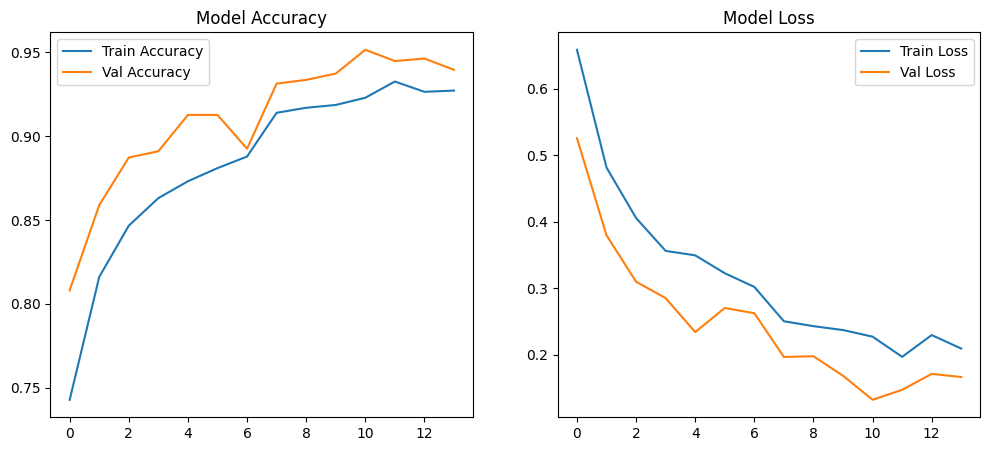

In [13]:
# ====================================================
# SECTION 7: Plot Accuracy and Loss
# ====================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


**Description:**

This still might shows how your model performed over time — helping you spot overfitting or improvement trends.

In [8]:
# ====================================================
# SECTION 8: Save Model
# ====================================================

model.save("plant_leaf_classifier_subset.h5")
print("✅ Model saved as plant_leaf_classifier_subset.h5")


✅ Model saved as plant_leaf_classifier_subset.h5


**Final Notes:**

Upload only your kaggle.json when the code asks — no manual dataset handling required.

The dataset will be automatically downloaded, subsetted, and used for CNN training.

You can later extend it to include all 38 classes from PlantVillage if needed.